<a href="https://colab.research.google.com/github/carloshernangarrido/deeplearning/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2


input data

11501568/11490434 [==============================] - 0s 0us/step


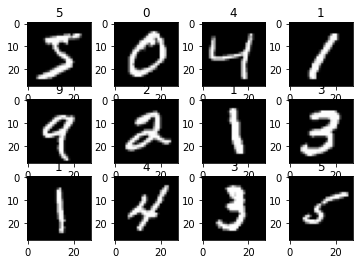

In [ ]:
(x_train_original, y_train_original), (x_test_original, y_test_original) = tf.keras.datasets.mnist.load_data()

n_samples = 12
fig, axs = plt.subplots(ncols=4, nrows = n_samples // 4)
axs1D = axs.flatten()
for i, x, y in zip(range(n_samples), x_train_original[0:n_samples], y_train_original[0:n_samples]):
  axs1D[i].imshow(x, cmap='gray')
  axs1D[i].set_title(label=y)

normalization

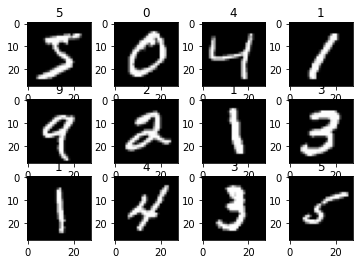

In [ ]:
x_train = x_train_original / 255.0
x_test = x_test_original / 255.0

n_samples = 12
fig, axs = plt.subplots(ncols=4, nrows = n_samples // 4)
axs1D = axs.flatten()
for i, x, y in zip(range(n_samples), x_train[0:n_samples], y_train_original[0:n_samples]):
  axs1D[i].imshow(x, cmap='gray')
  axs1D[i].set_title(label=y)

model definition

In [ ]:
def create_model_dense(input_dim, output_dim, internal_dim):
  # Encoder
  encoder_input = keras.Input(shape=input_dim, name='image')
  x = keras.layers.Flatten()(encoder_input)
  encoder_output = keras.layers.Dense(units=internal_dim, activation='relu')(x)

  # Bottleneck  
  decoder_input = encoder_output
    
  # Decoder
  x = keras.layers.Dense(units=output_dim[0]*output_dim[1], activation='relu')(decoder_input)
  decoder_output = keras.layers.Reshape(target_shape=output_dim)(x)
  return keras.Model(inputs=encoder_input, outputs=decoder_output, name='autoencoder'), \
    keras.Model(inputs=encoder_input, outputs=encoder_output, name='encoder'), \
    keras.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')

def create_model_conv(input_dim, output_dim, internal_dim):
  # Encoder
  encoder_input = keras.Input(shape=input_dim, name='image')
  x = keras.layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(encoder_input)
  x = keras.layers.Conv2D(32, (3, 3), strides=1, activation="relu", padding="same")(x)
  x = keras.layers.Flatten()(x)
  encoder_output = keras.layers.Dense(units=internal_dim)(x)
  
  # Bottleneck  
  decoder_input = encoder_output
  
  # Decoder
  x = keras.layers.Dense(units=input_dim[0]*input_dim[1]*32, activation="relu")(decoder_input)
  x = keras.layers.Reshape((input_dim[0], input_dim[1], 32))(x)
  x = keras.layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
  x = keras.layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
  decoder_output = keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

  return keras.Model(inputs=encoder_input, outputs=decoder_output, name='autoencoder'), \
    keras.Model(inputs=encoder_input, outputs=encoder_output, name='encoder'), \
    keras.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')


latent_dim = 10
# aenc_model, enc_model = create_model_dense((28, 28), (28, 28), latent_dim)
aenc_model, enc_model, dec_model = create_model_conv((28, 28, 1), (28, 28, 1), latent_dim)


aenc_model.summary()
enc_model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)# optimizer
aenc_model.compile(opt, loss='mse')


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                                 
 dense_1 (Dense)             (None, 25088)             275968    
                                                                 
 reshape (Reshape)           (None, 28, 28, 32)        

model train

In [ ]:
aenc_model.fit(x_train, x_train, batch_size=32, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 592s 315ms/step - loss: 0.0232
Epoch 2/3
1875/1875 [==============================] - 598s 319ms/step - loss: 0.0140
Epoch 3/3
1875/1875 [==============================] - 608s 324ms/step - loss: 0.0129


model test

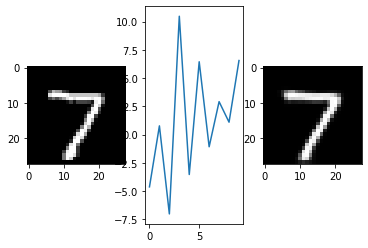

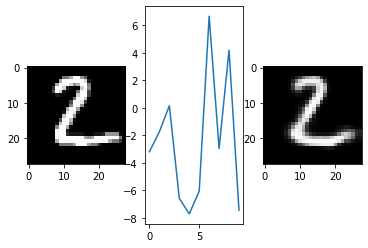

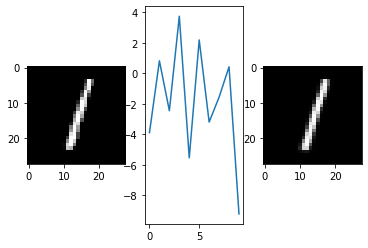

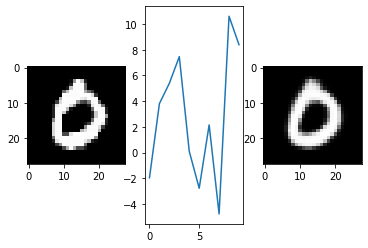

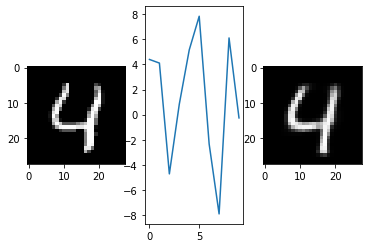

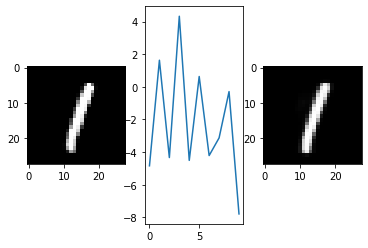

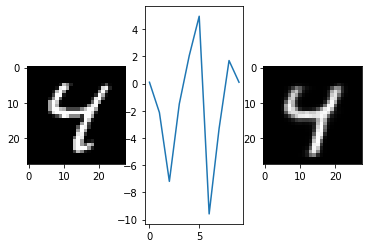

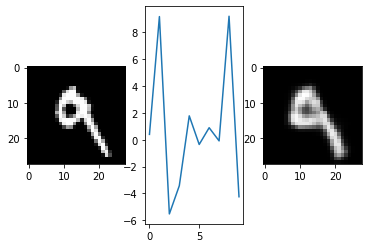

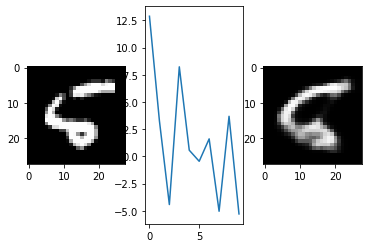

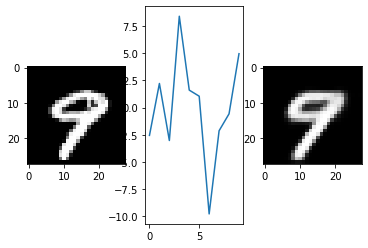

In [ ]:
for i_test in range(10):
  enc_out = enc_model.predict(x_test[i_test].reshape(-1, 28, 28))
  aenc_out = aenc_model.predict(x_test[i_test].reshape(-1, 28, 28))

  fig, axs = plt.subplots(ncols=3, nrows=1)
  axs1D = axs.flatten()
  axs1D[0].imshow(x_test[i_test], cmap='gray')
  axs1D[1].plot(np.array(range(latent_dim)).reshape((1, latent_dim)).T, enc_out.T)
  axs1D[2].imshow(aenc_out.reshape(28,28), cmap='gray')


model test with downsampled images

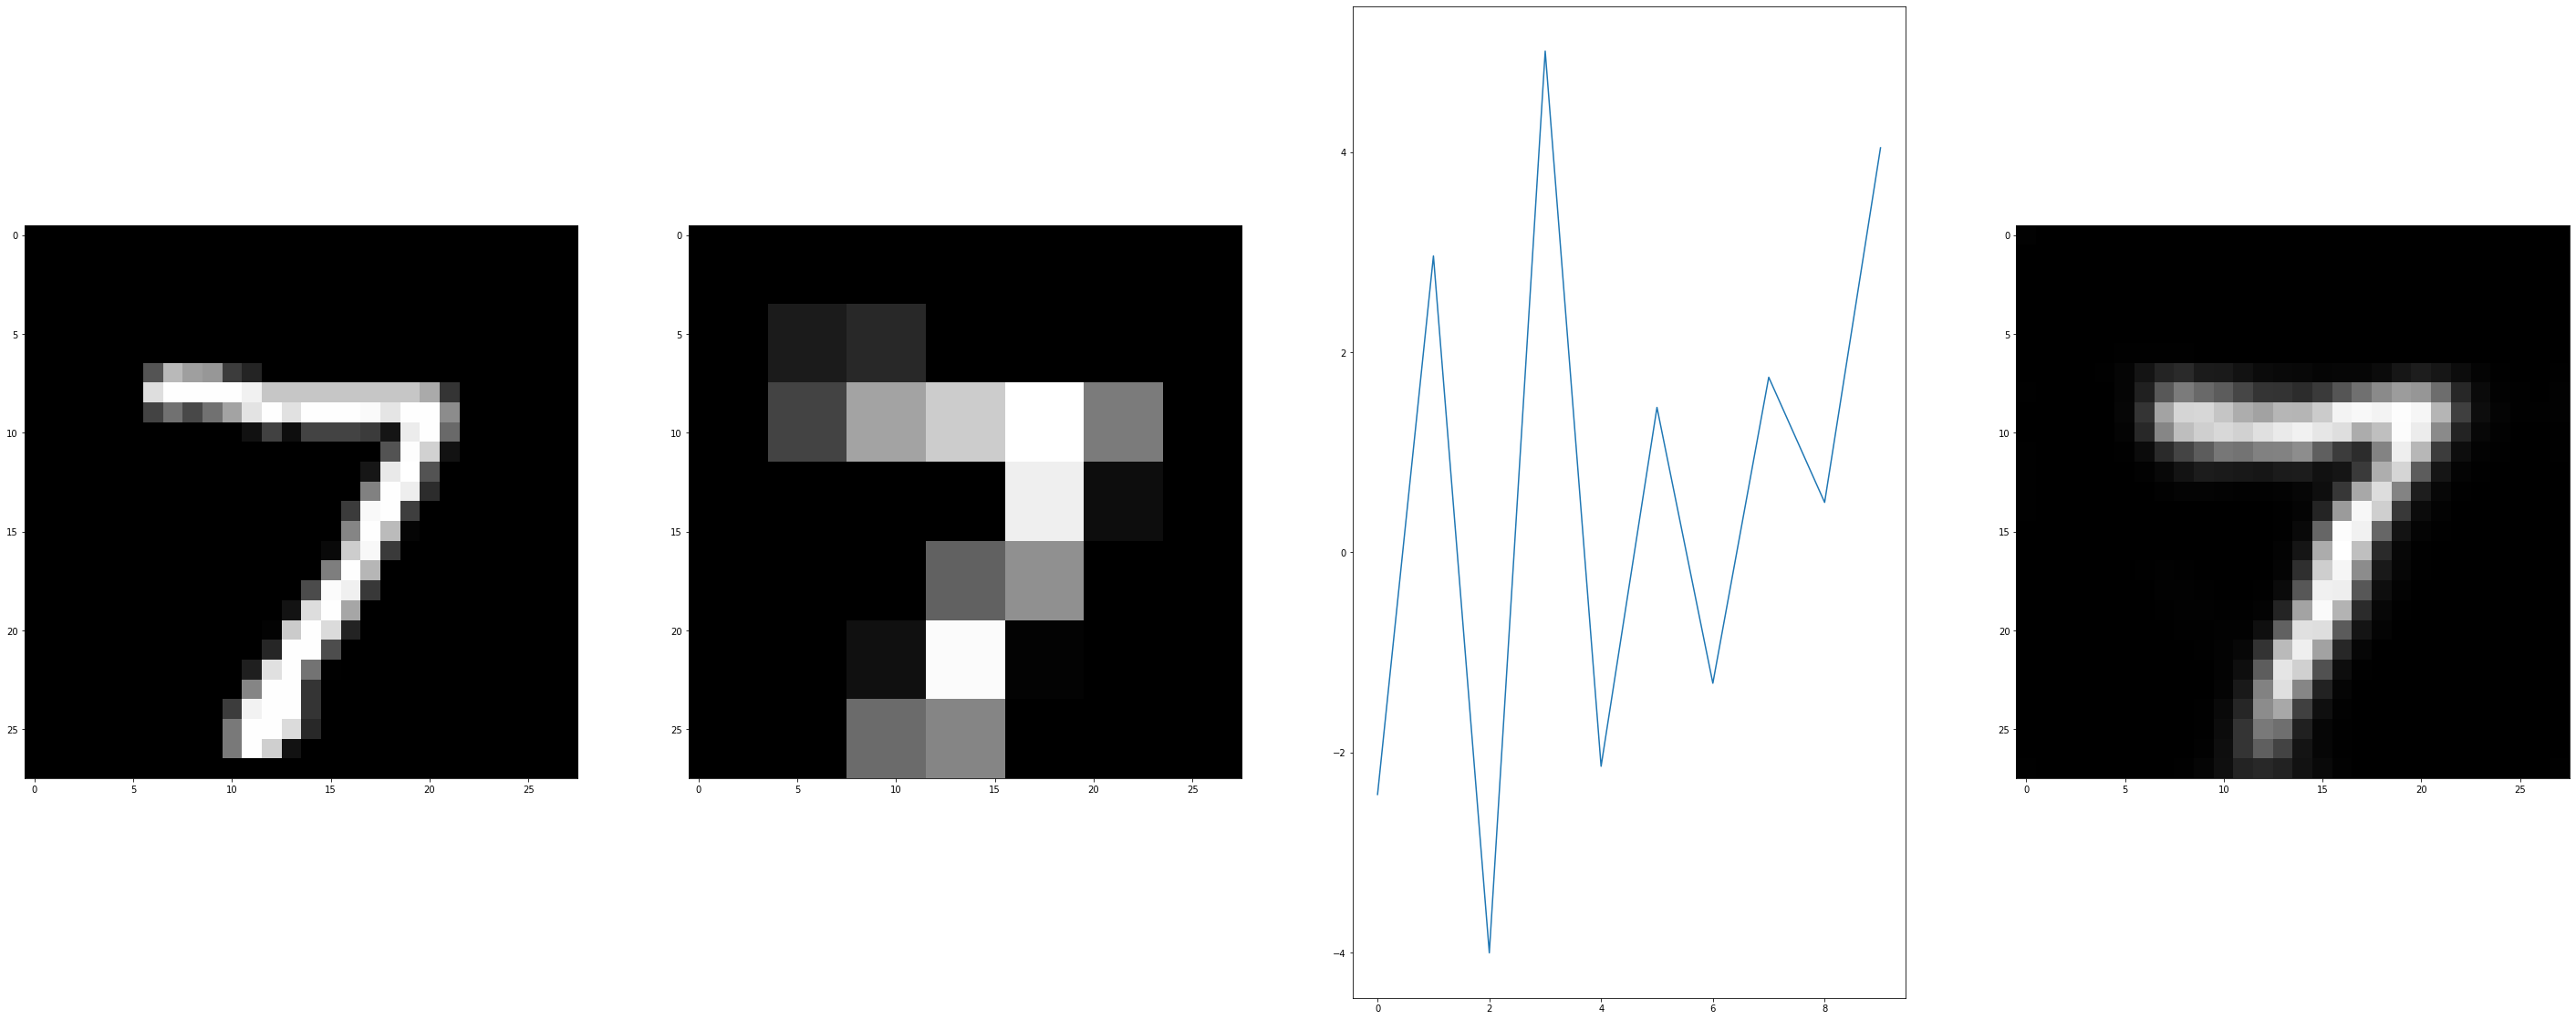

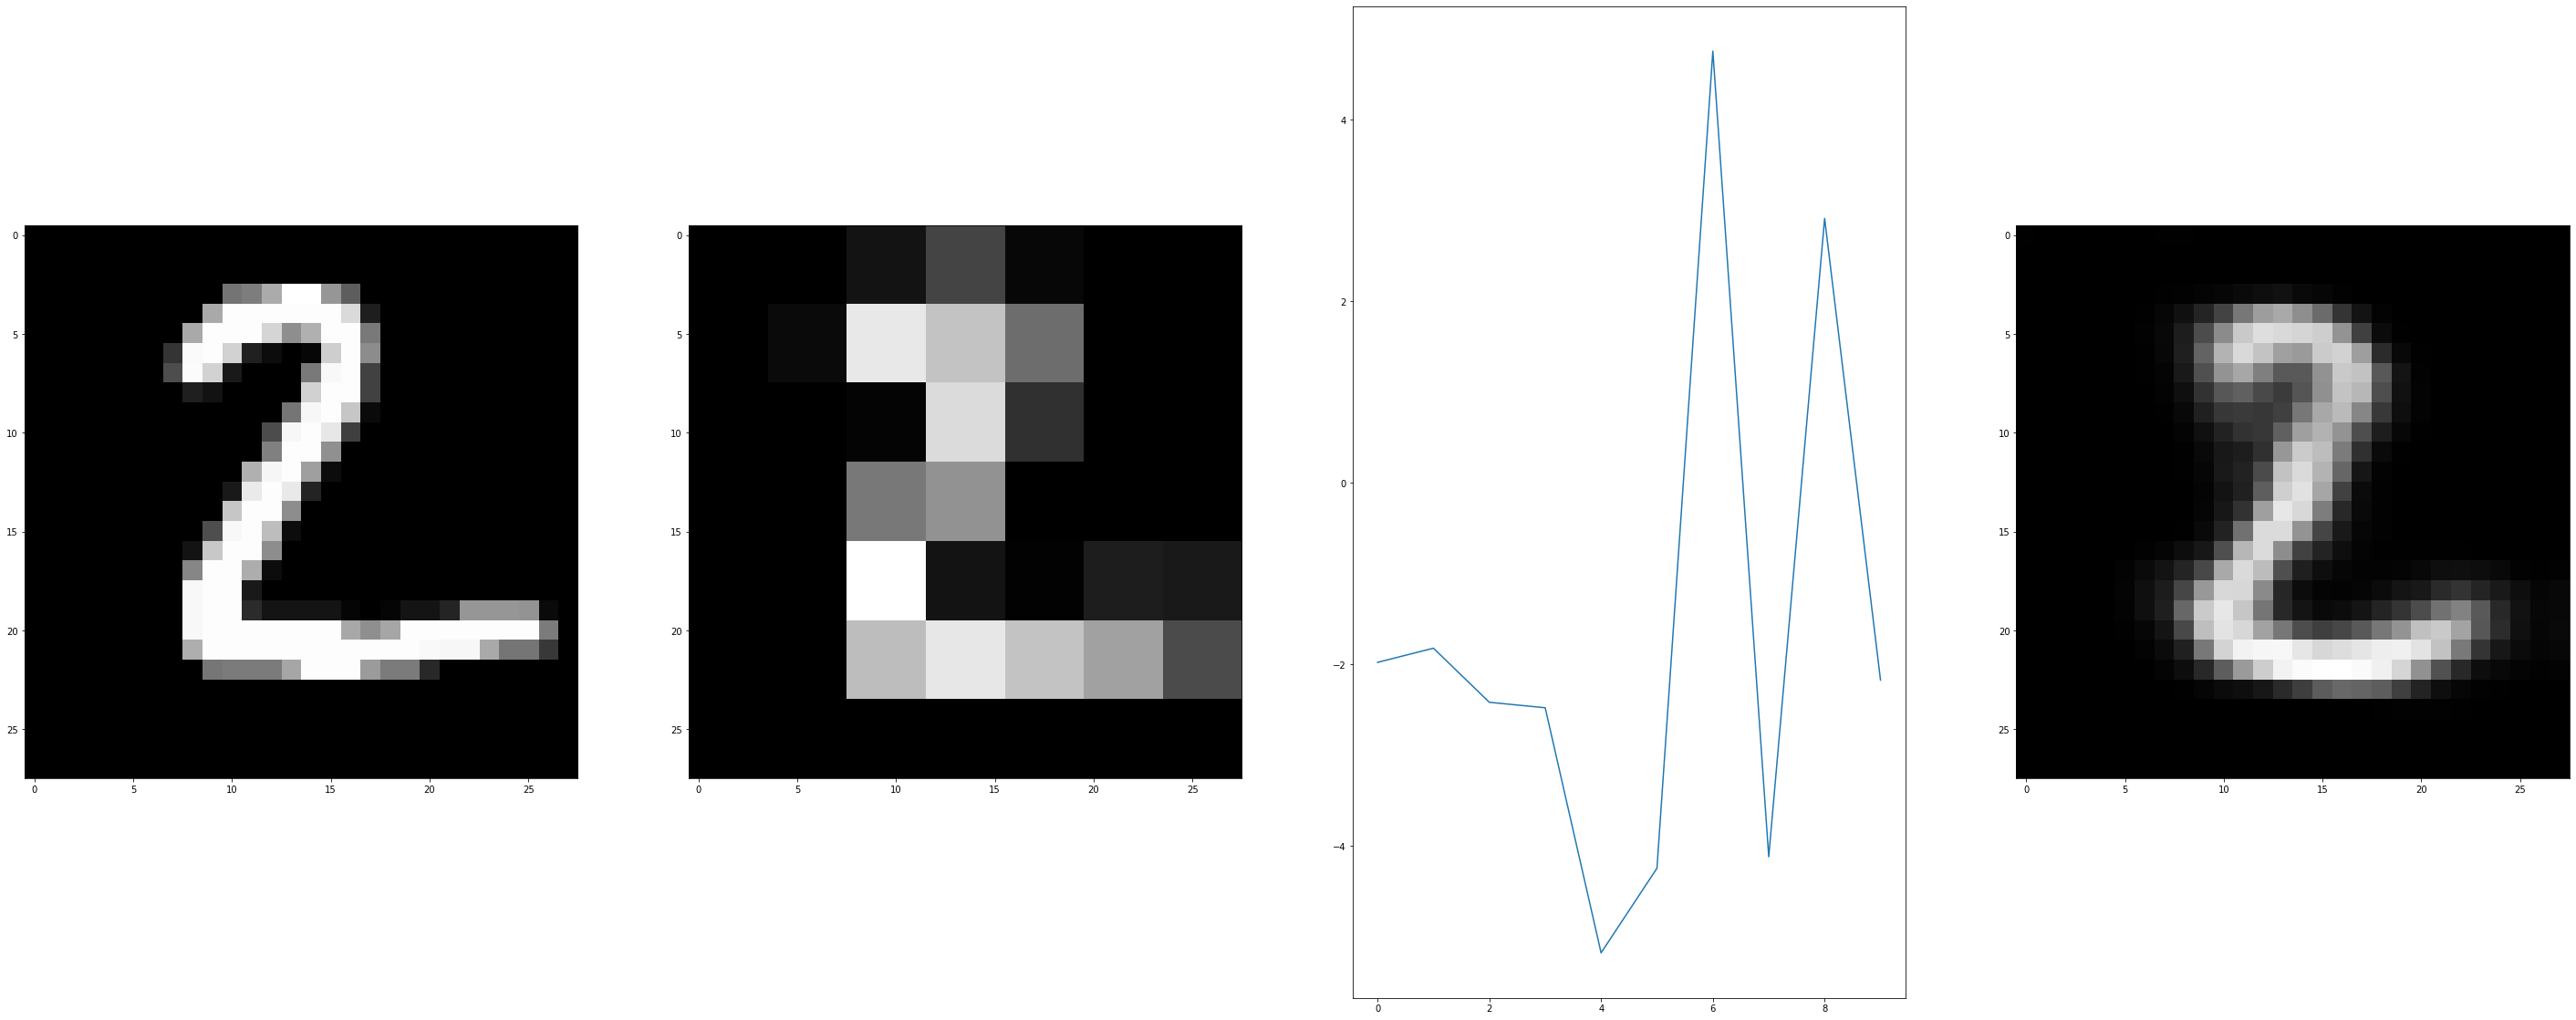

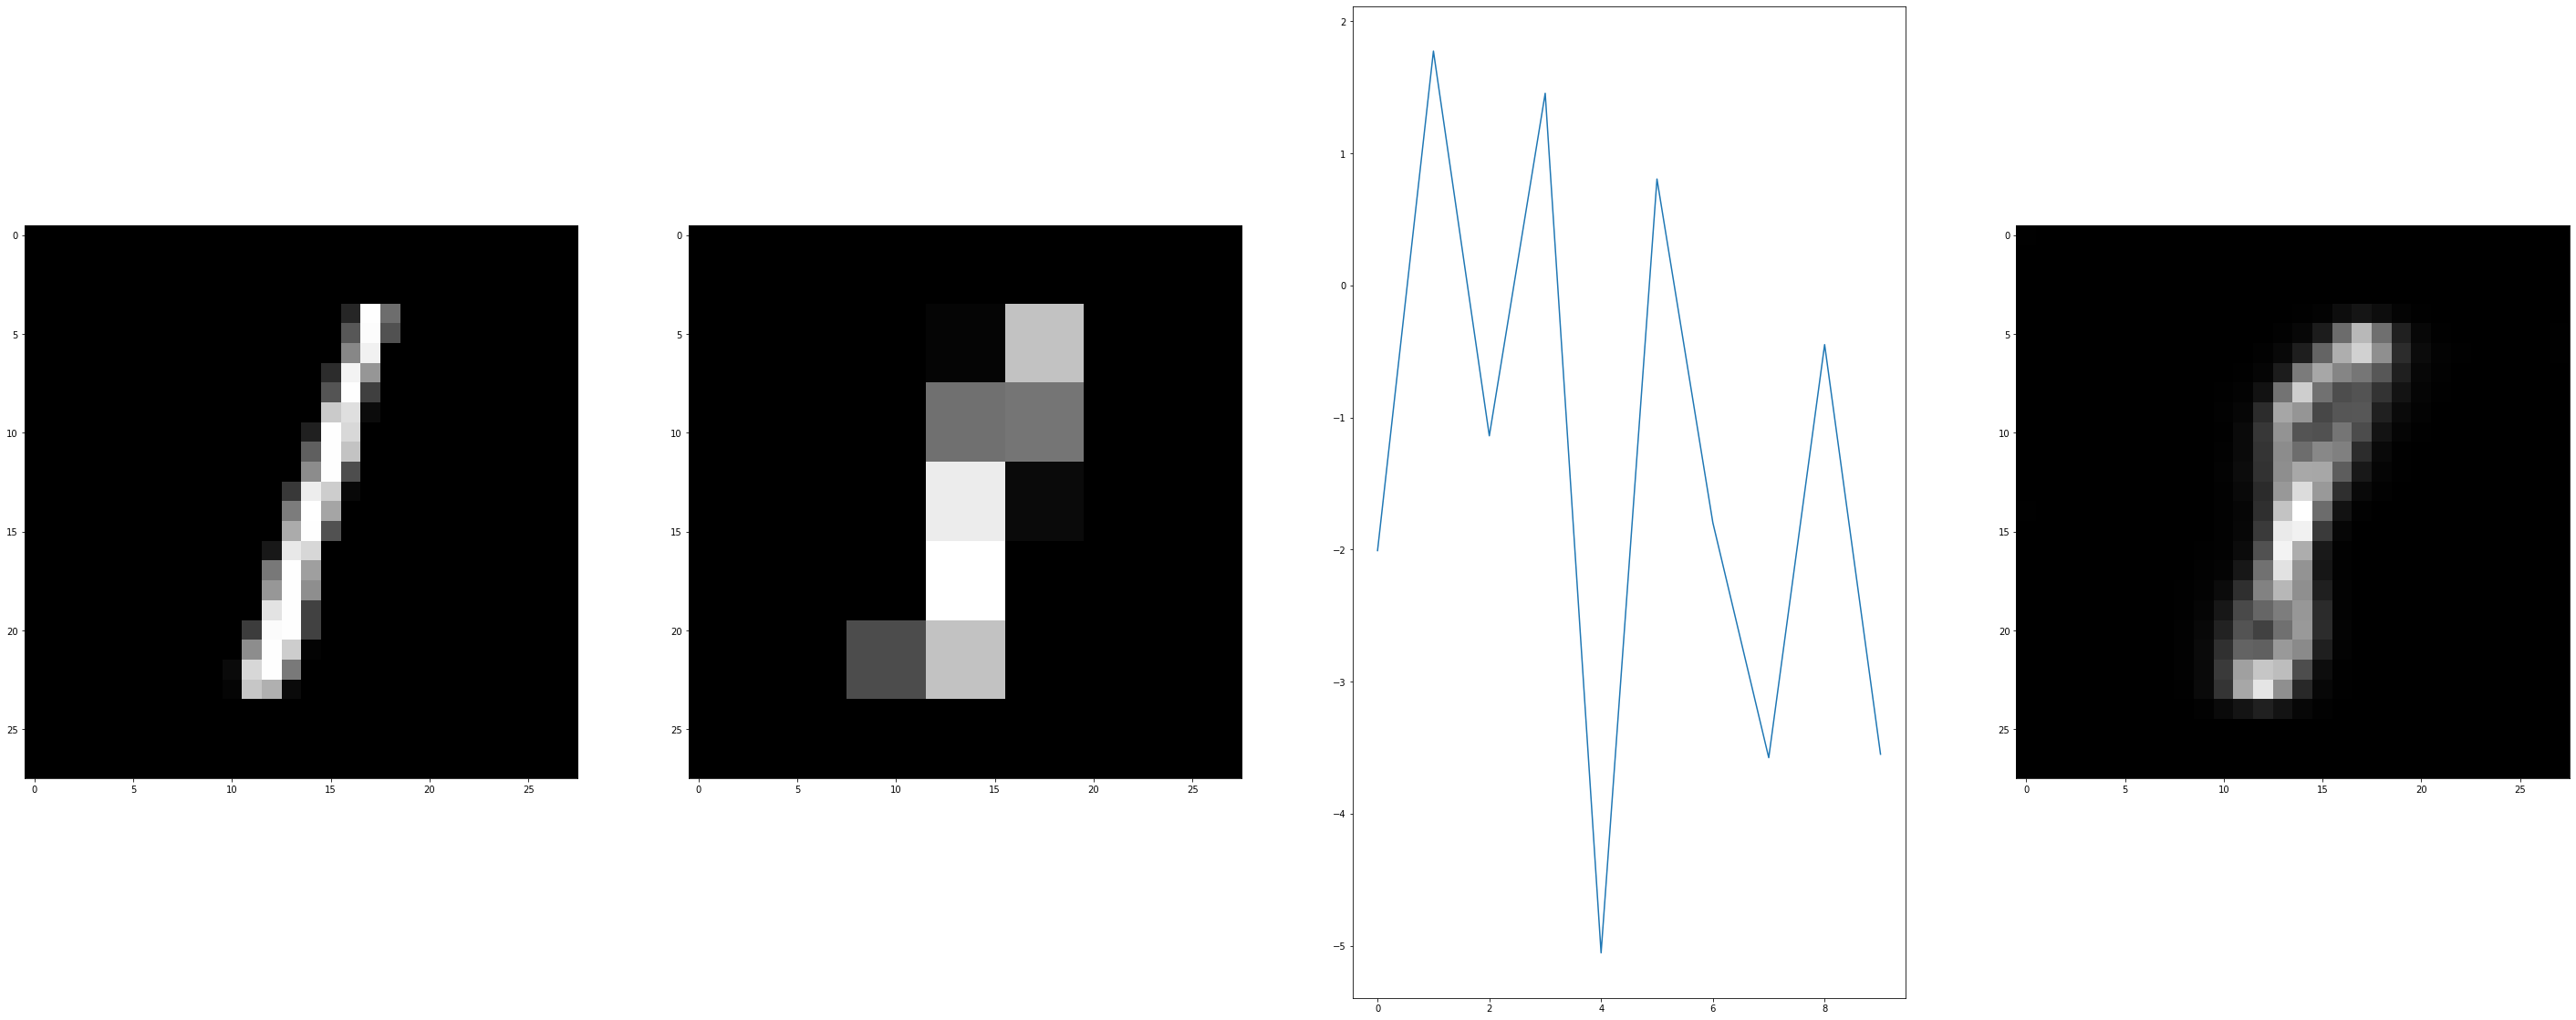

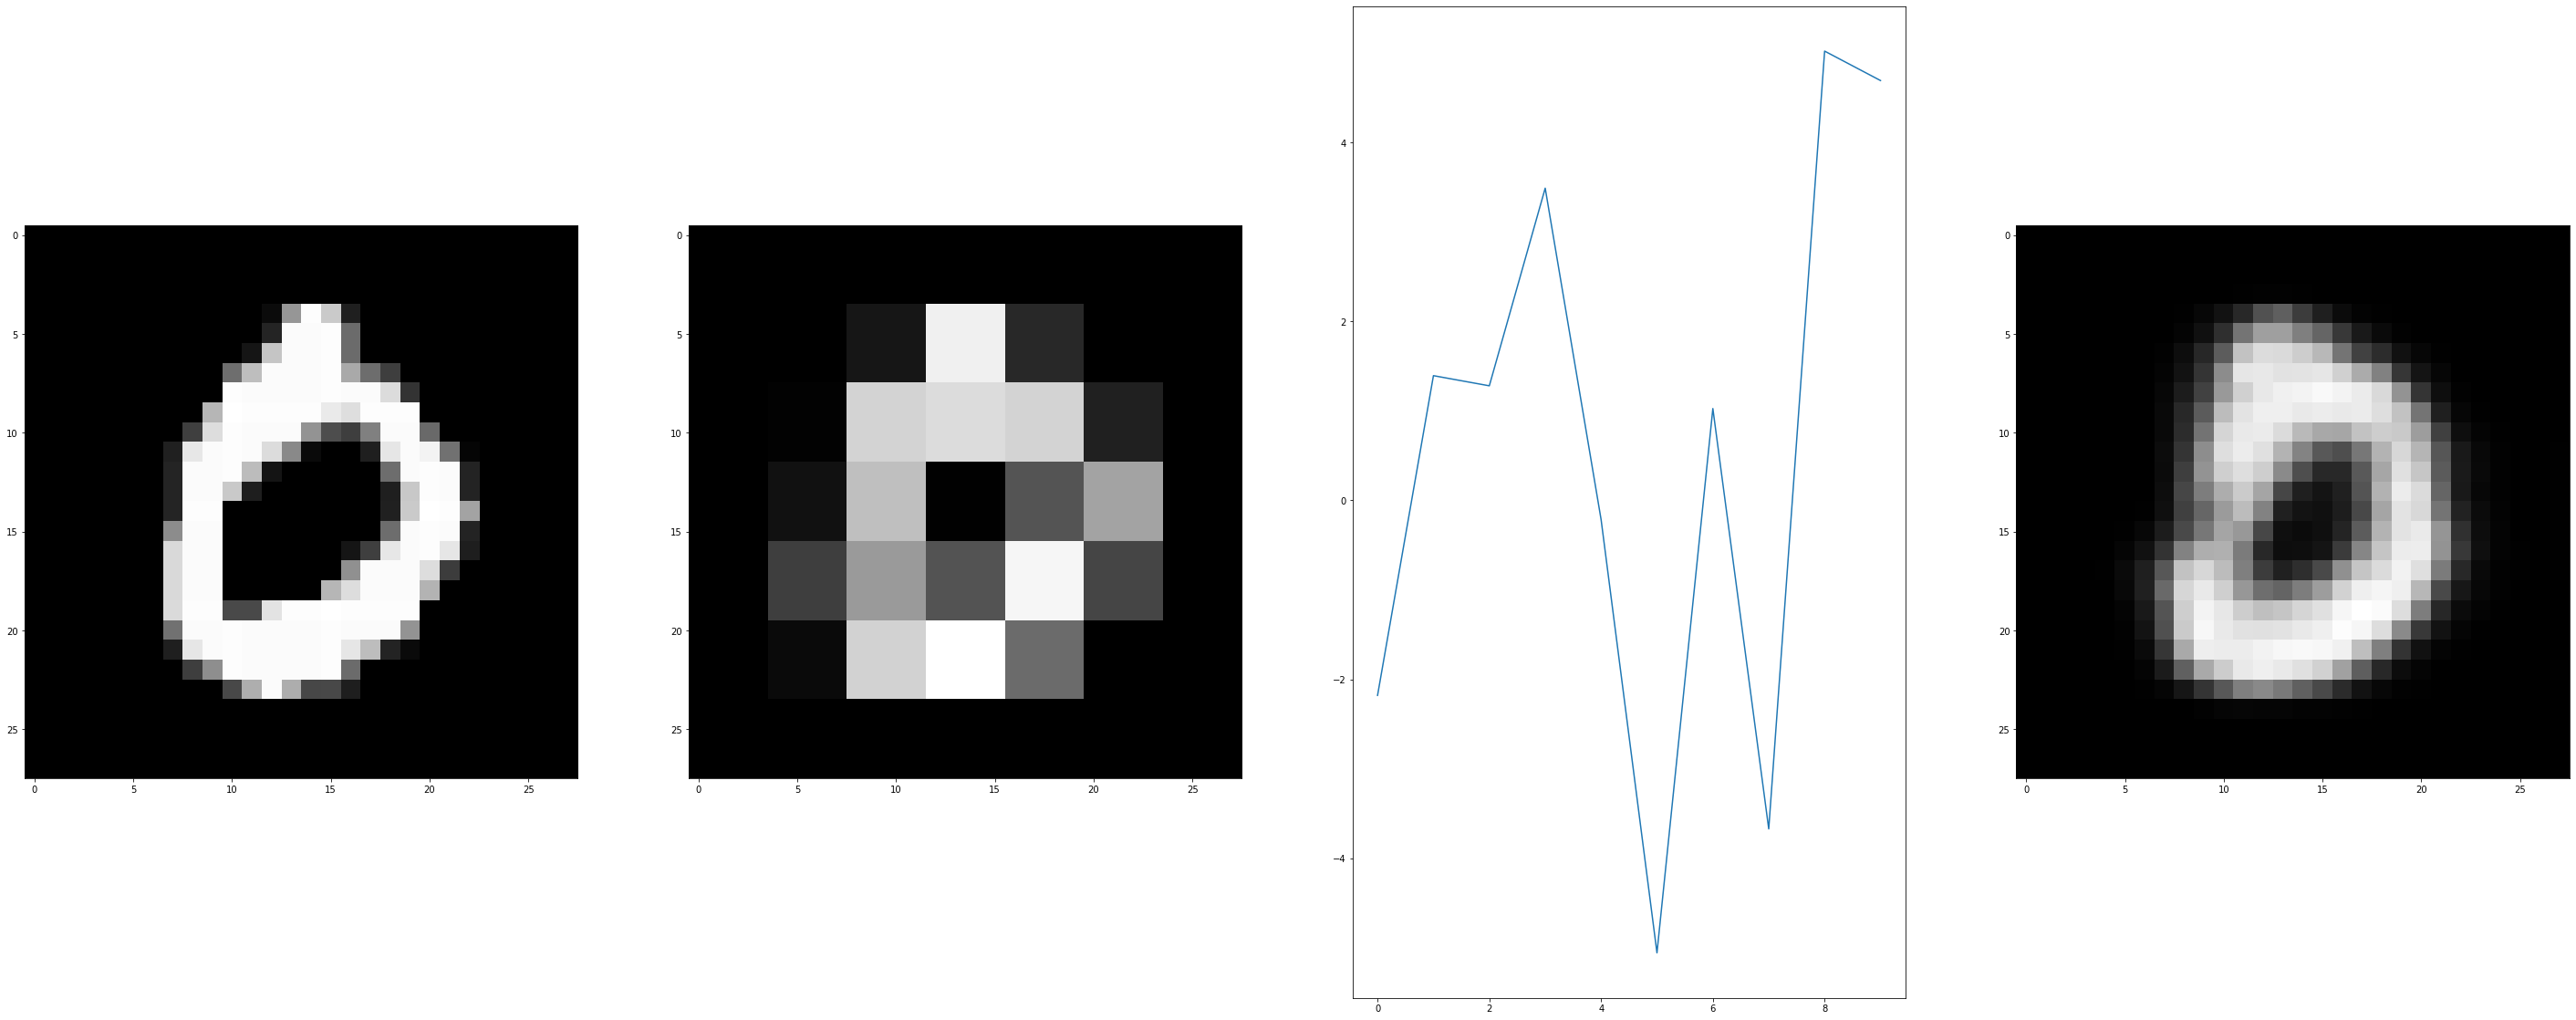

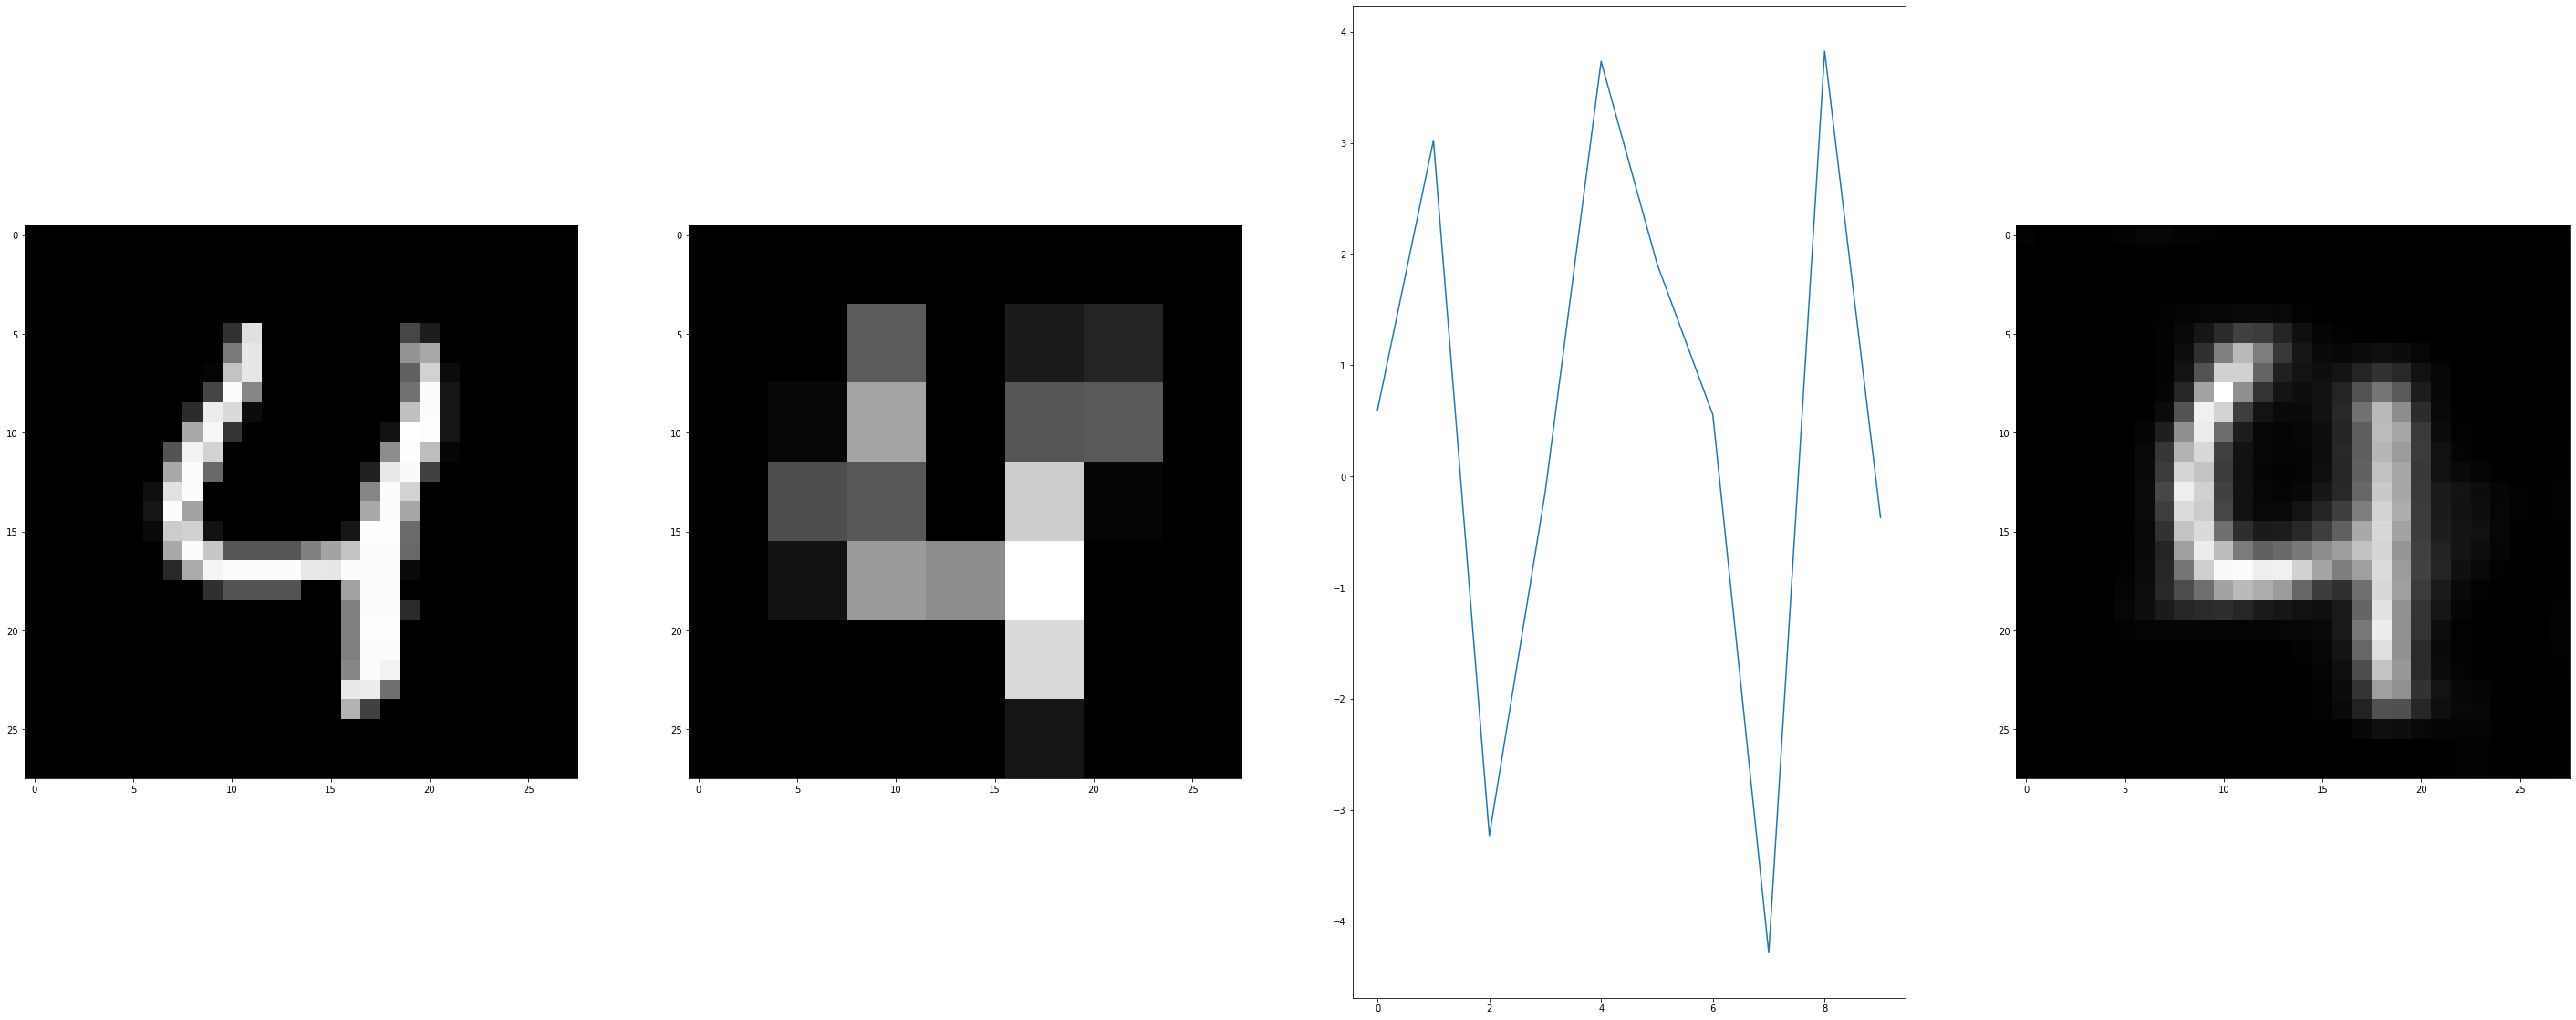

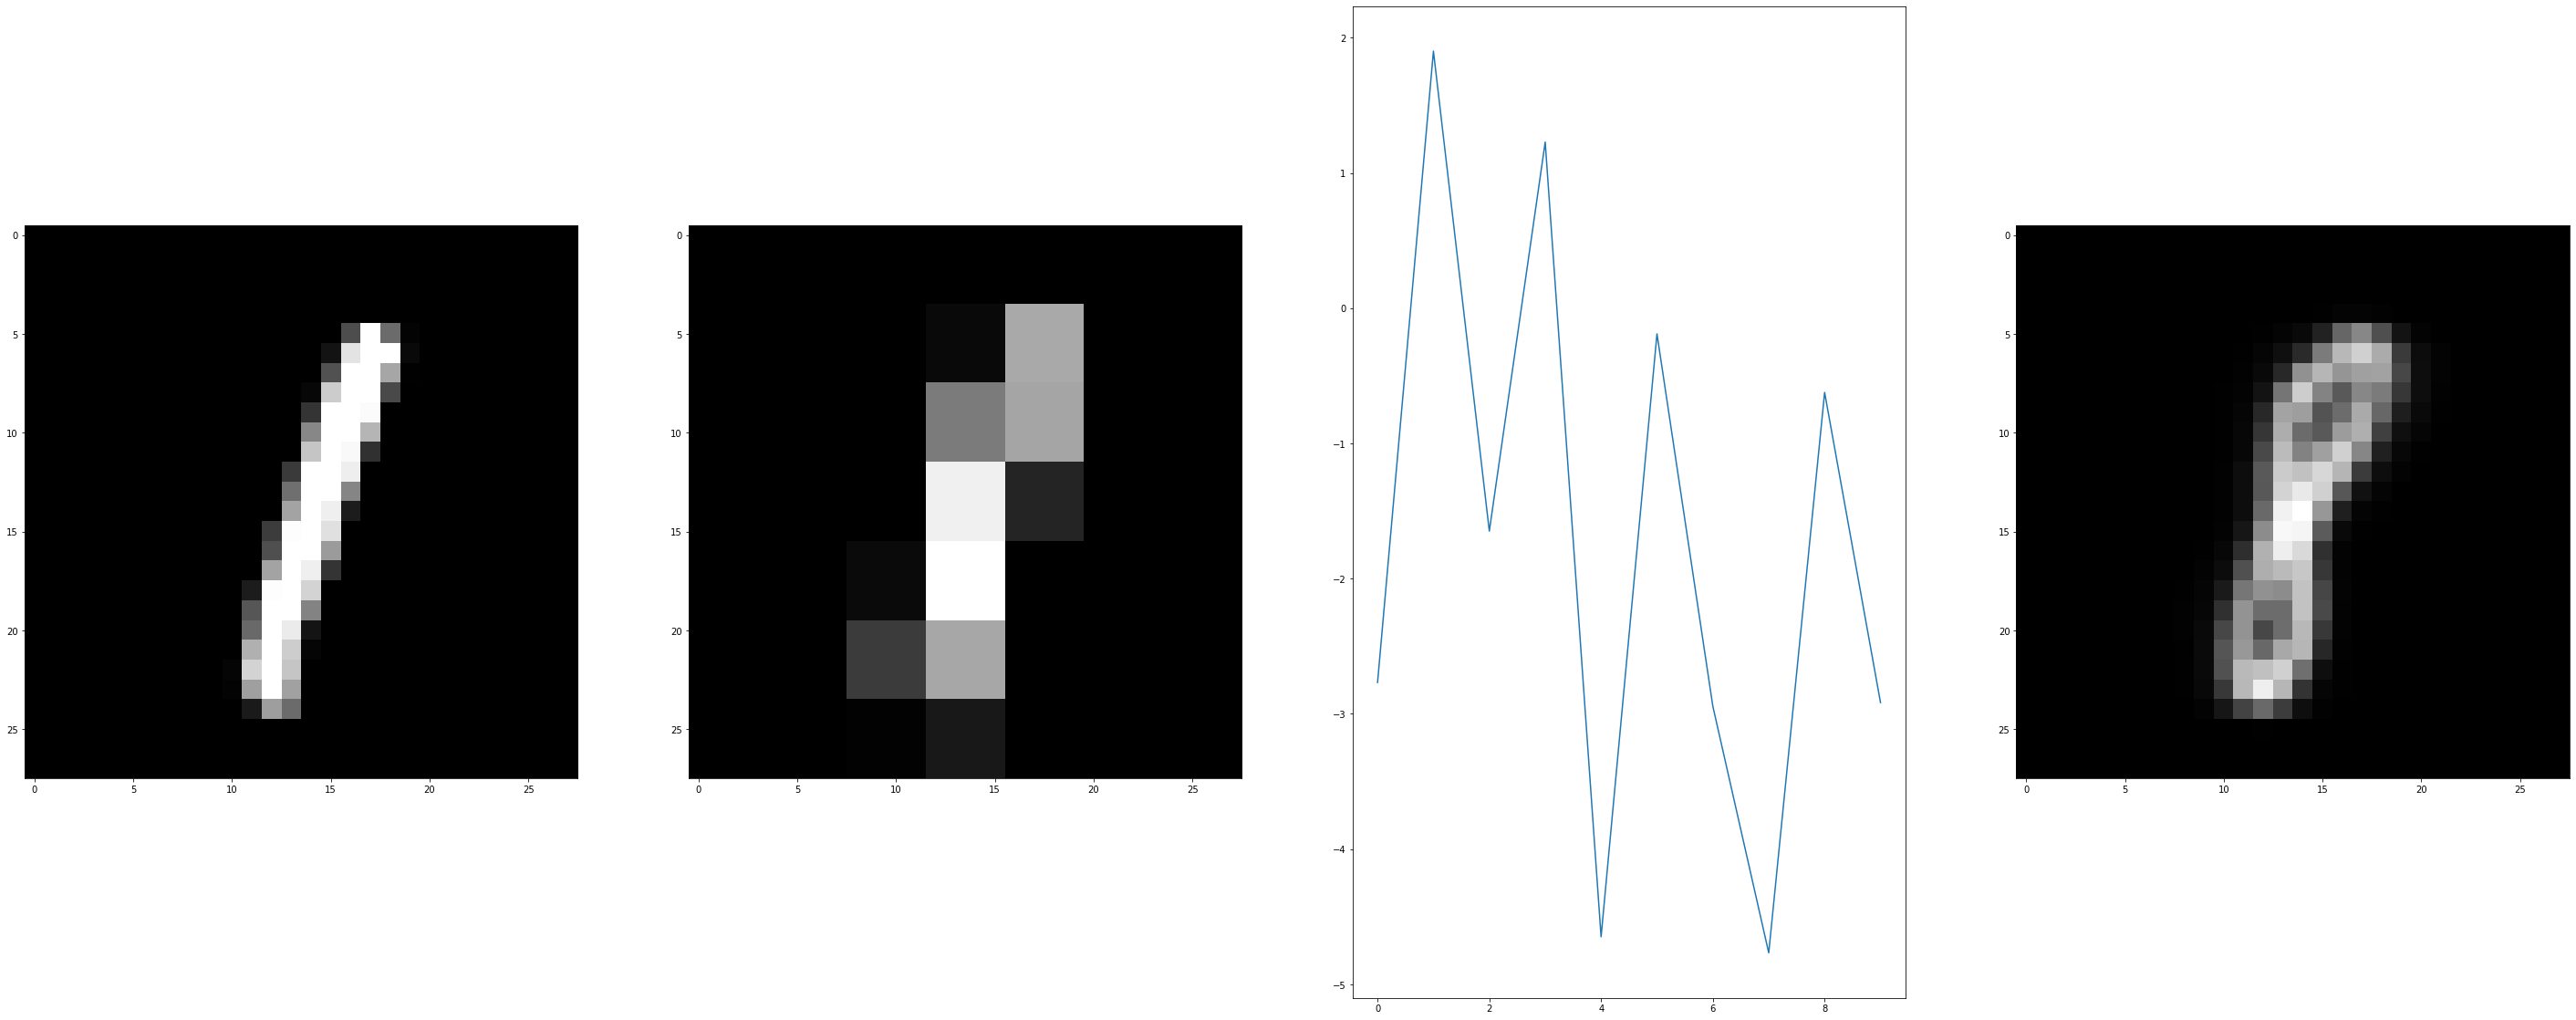

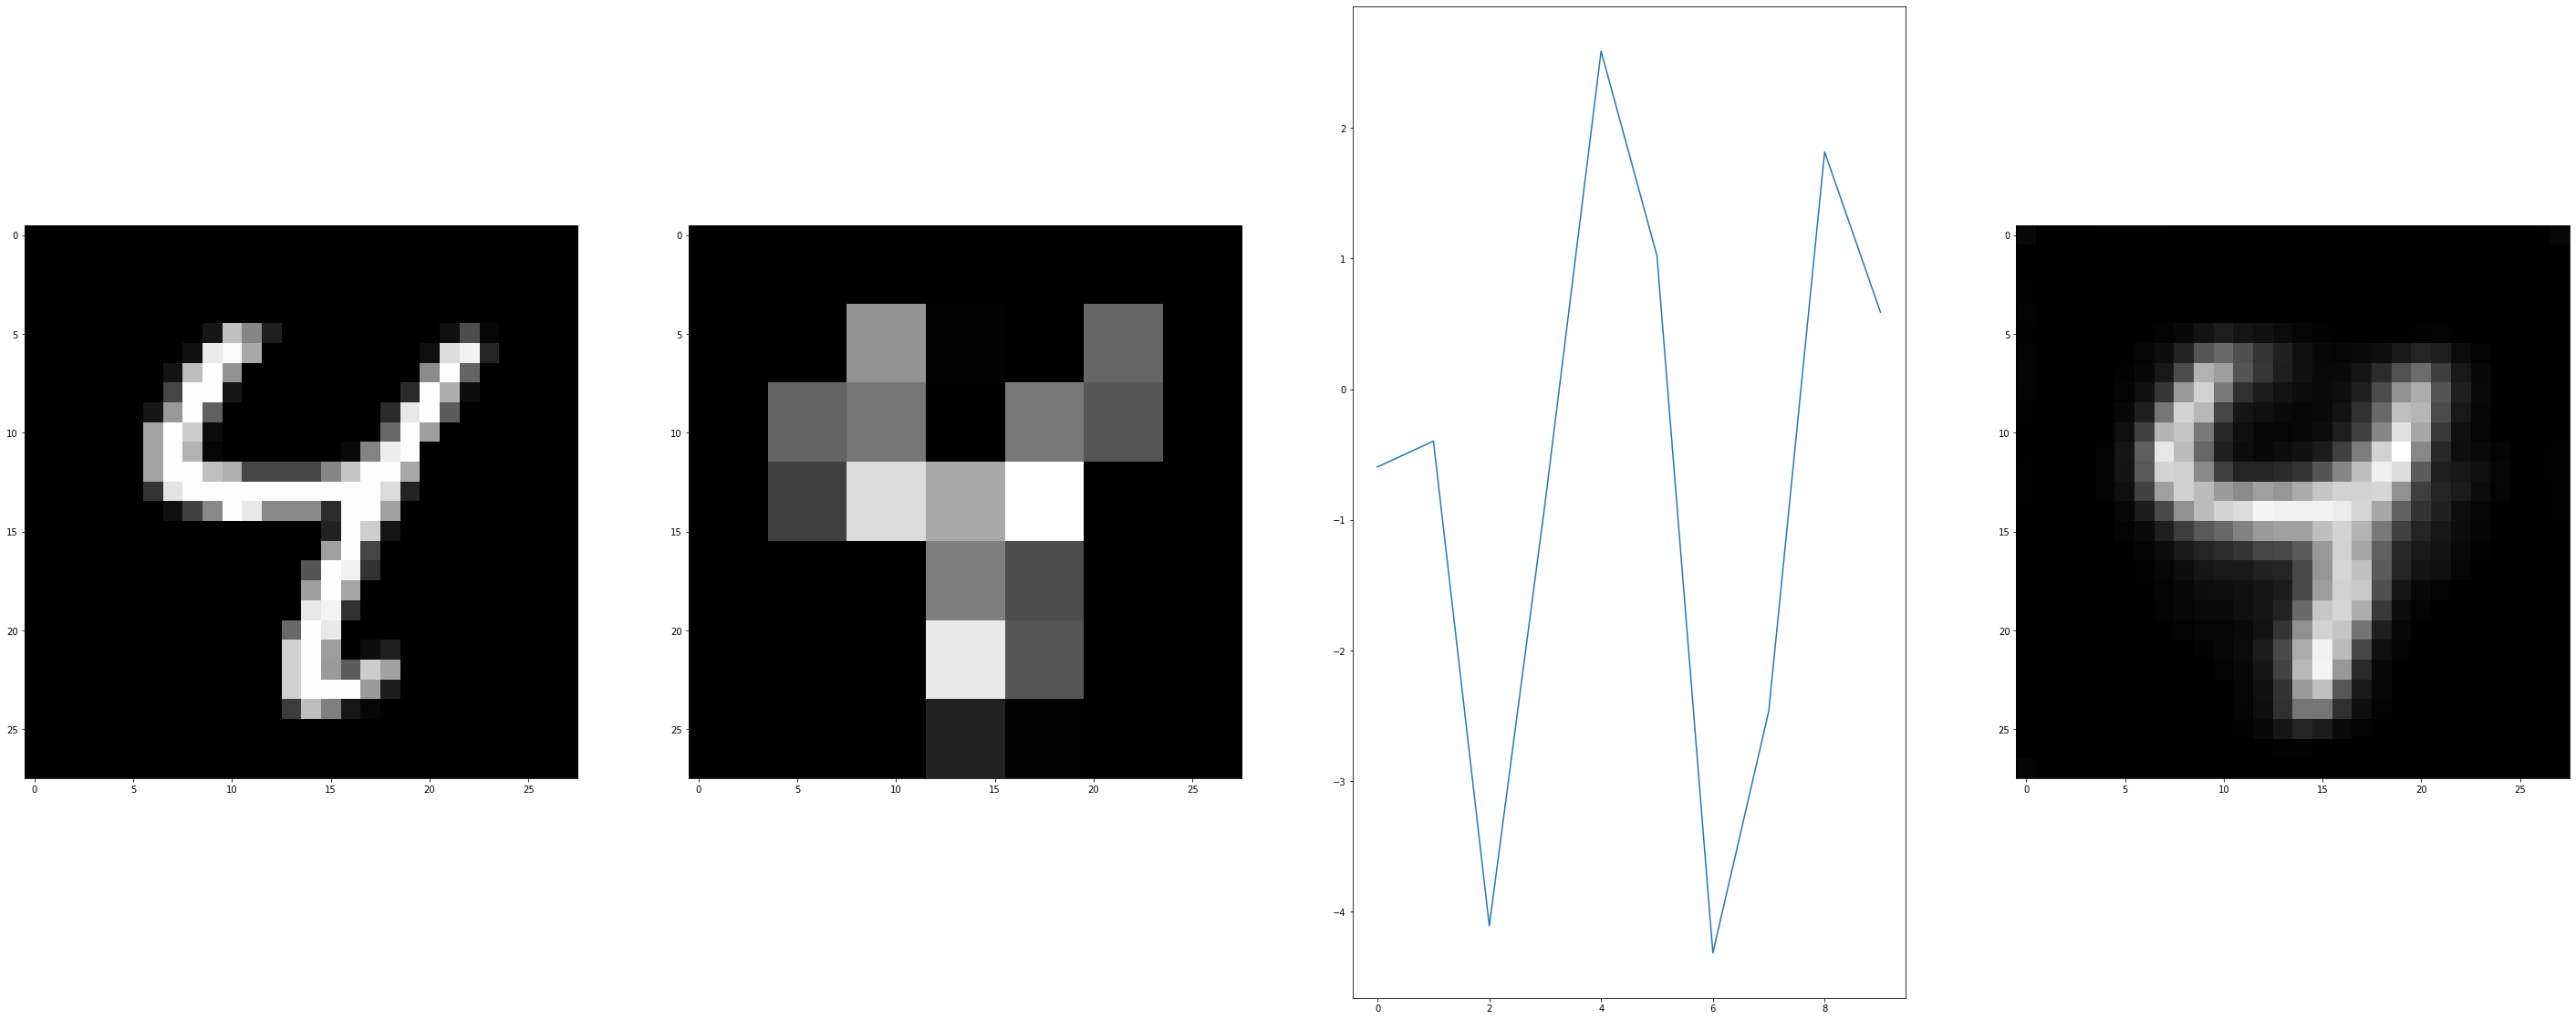

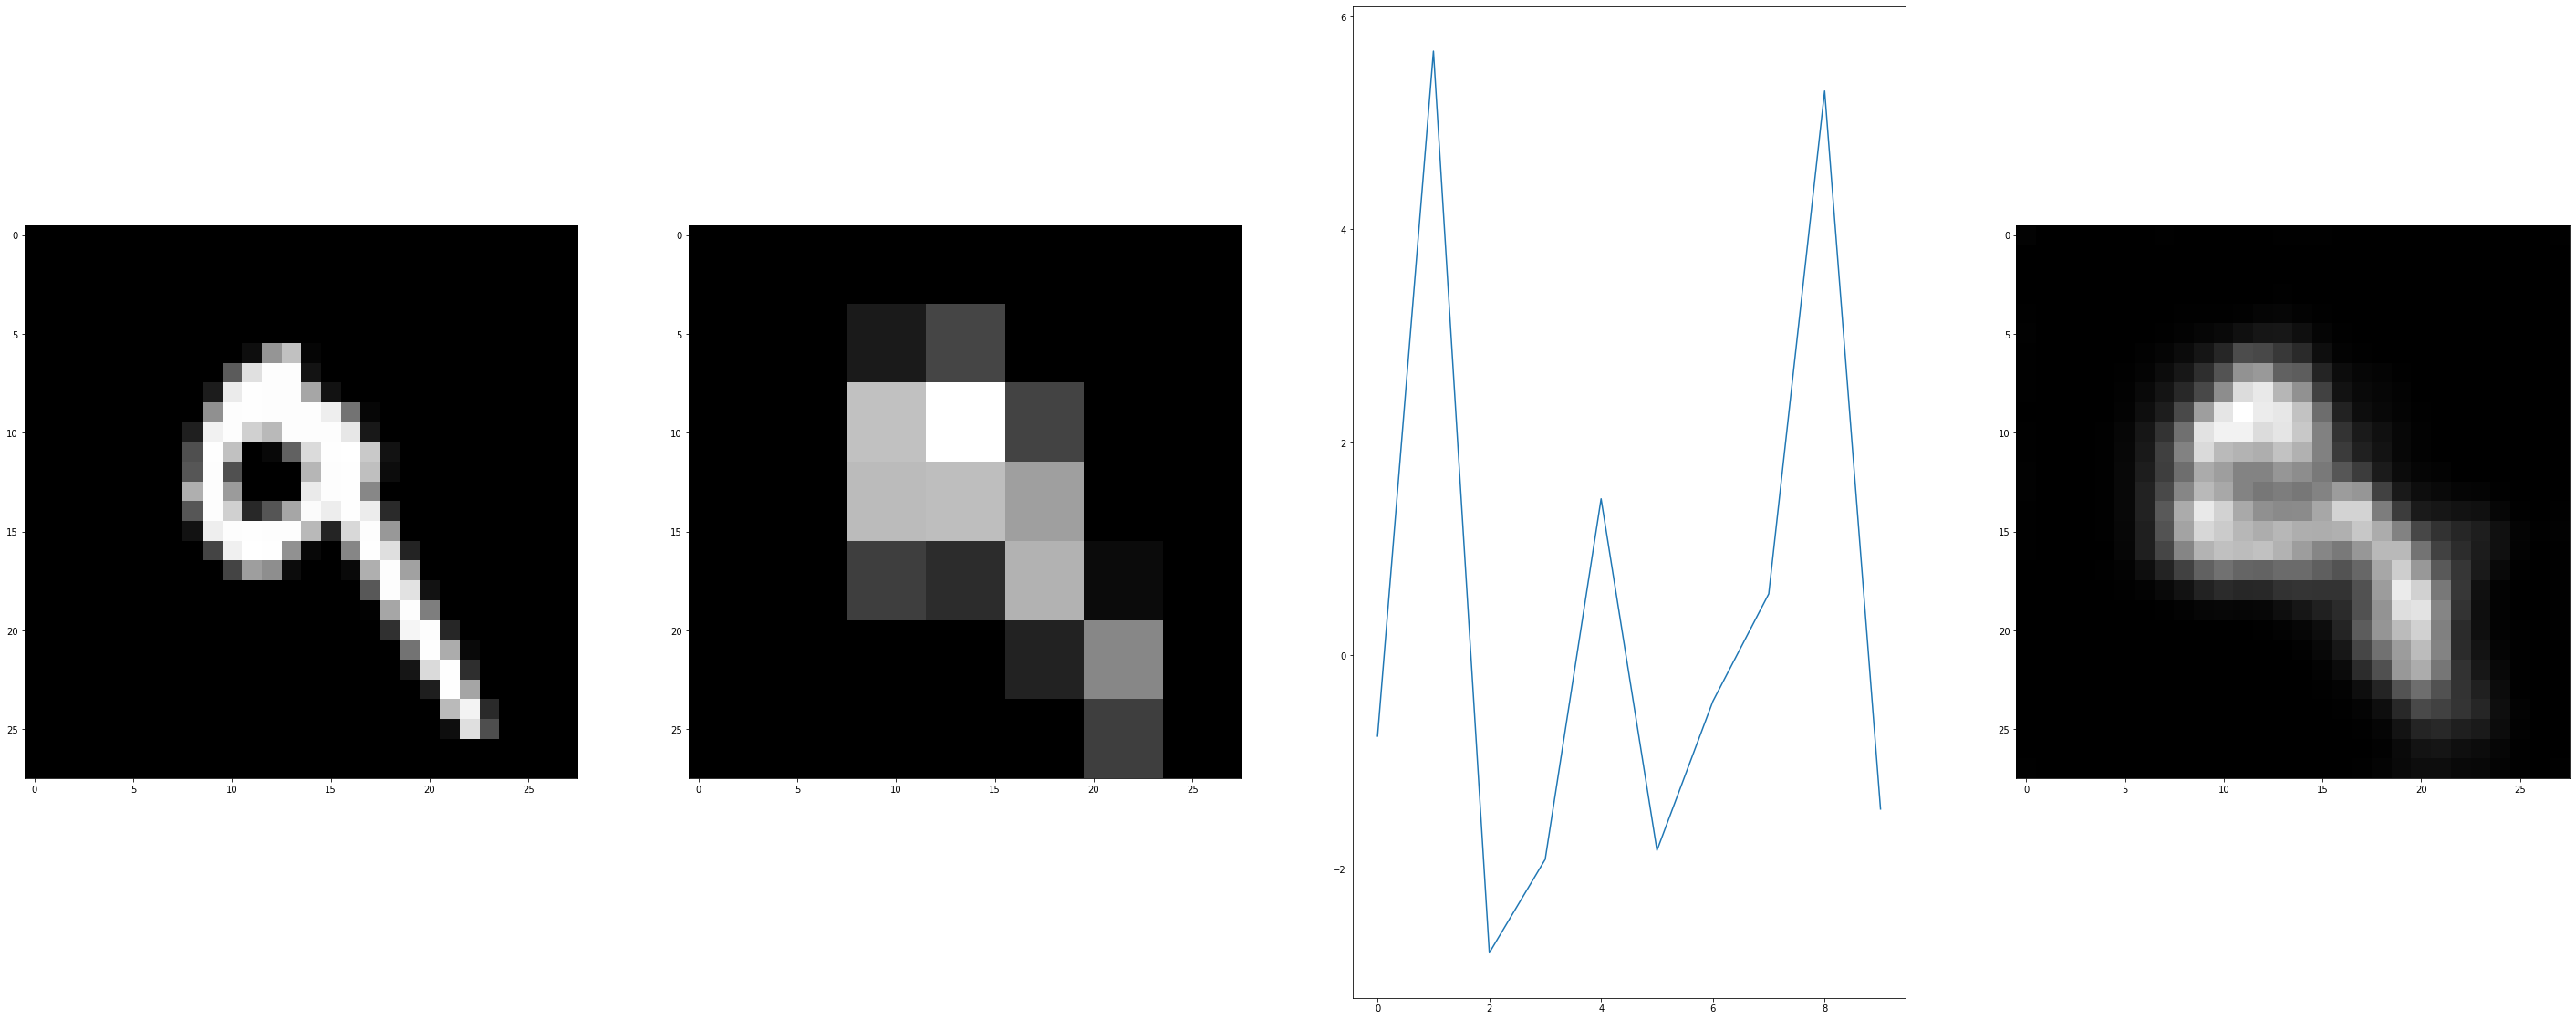

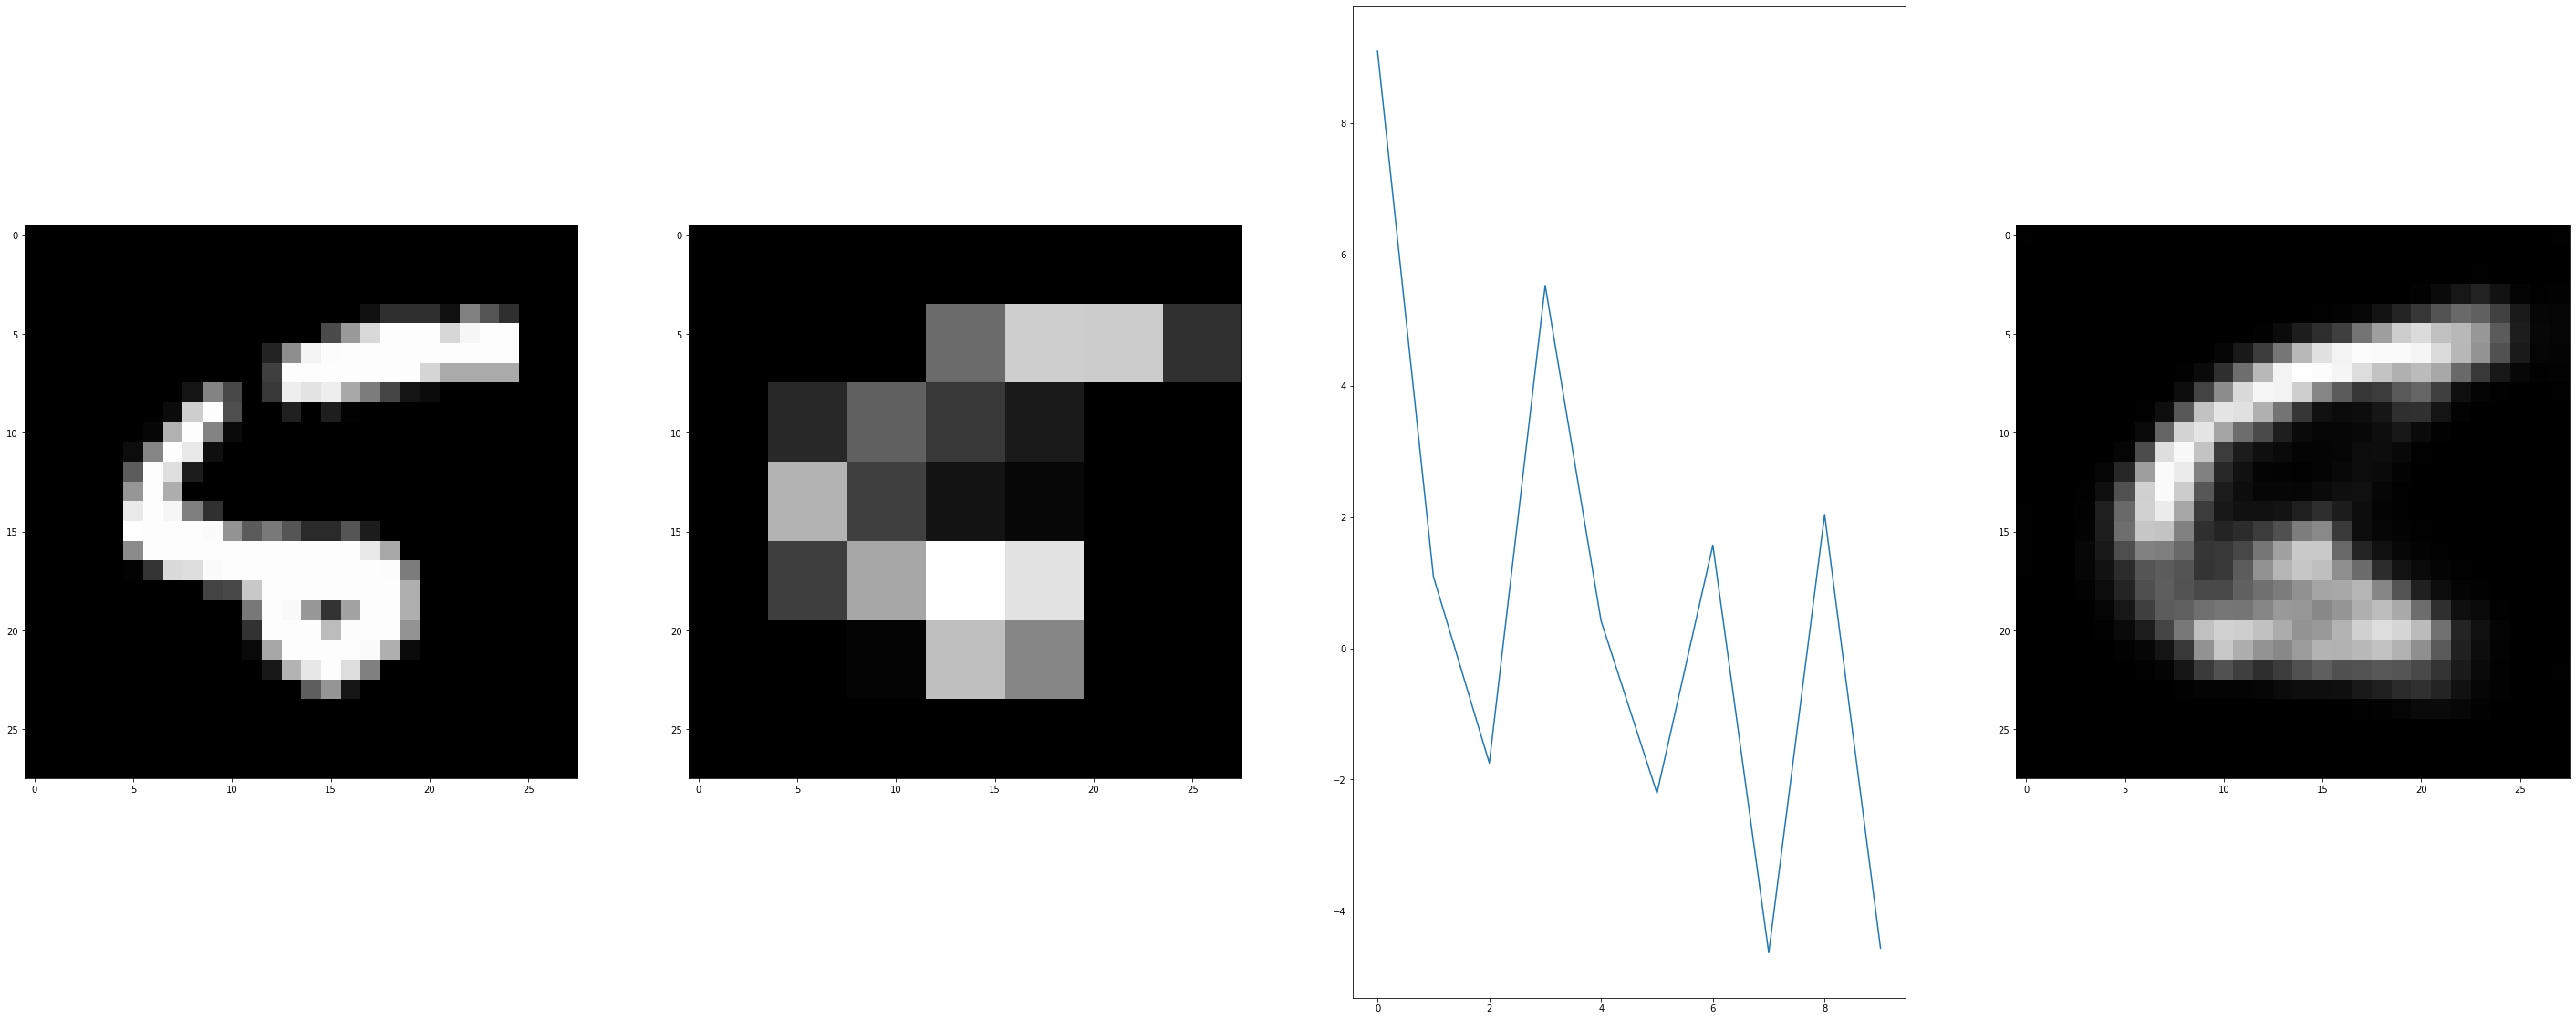

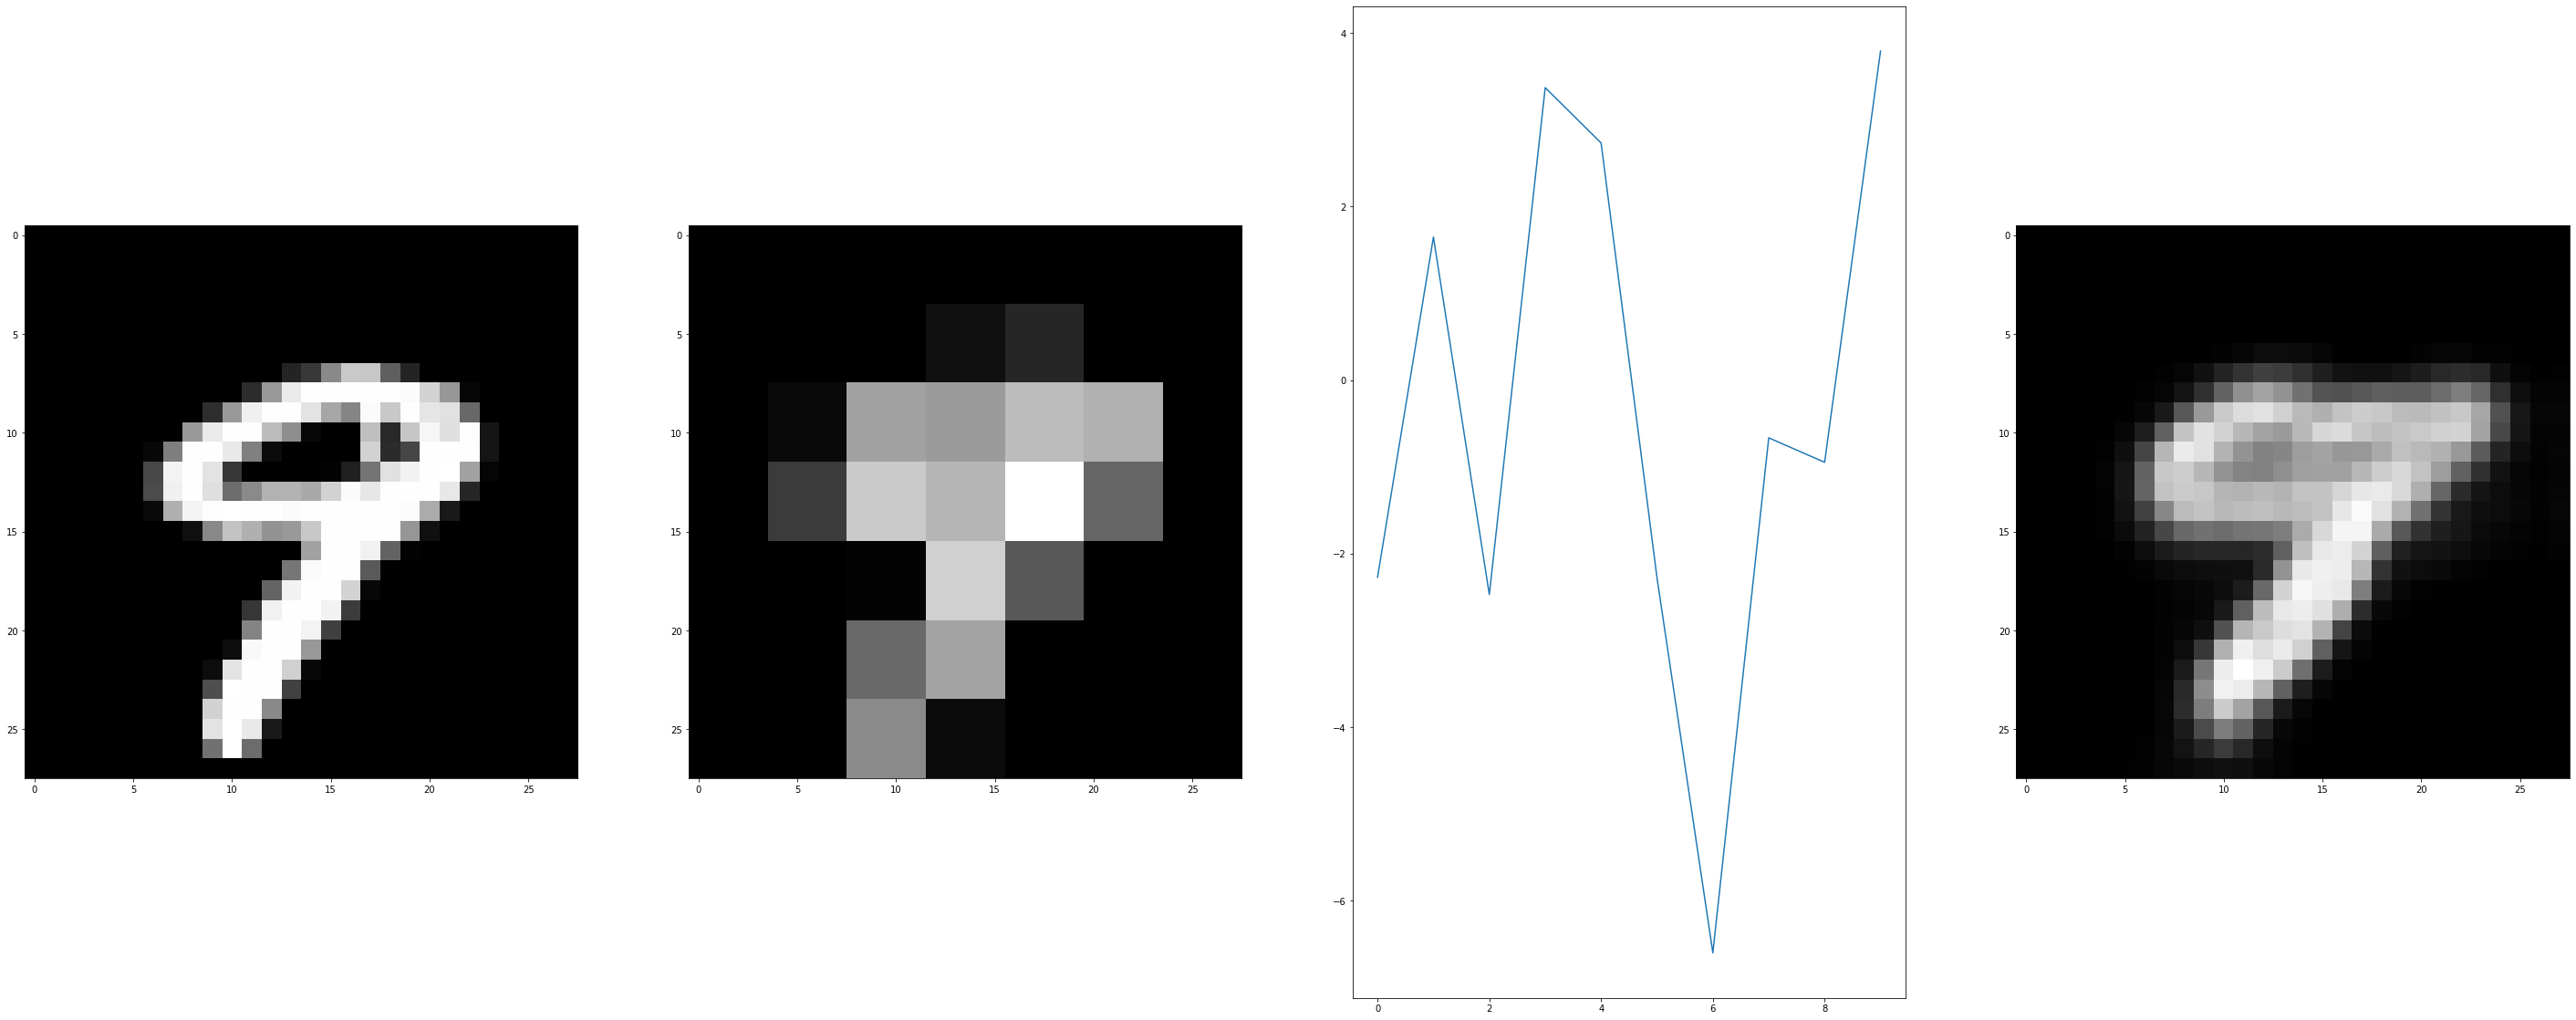

In [ ]:
from numpy.core.fromnumeric import size
decimation = 4
for i_test in range(10):
  img = x_test[i_test]
  img_ = cv2.resize(img, (img.shape[1]//decimation, img.shape[0]//decimation), interpolation=cv2.INTER_AREA)
  downsampled = cv2.resize(img_, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
  enc_out = enc_model.predict(downsampled.reshape(-1, 28, 28))
  aenc_out = aenc_model.predict(downsampled.reshape(-1, 28, 28))

  fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(50,20))
  axs1D = axs.flatten()
  axs1D[0].imshow(img, cmap='gray')
  axs1D[1].imshow(downsampled, cmap='gray')
  axs1D[2].plot(np.array(range(latent_dim)).reshape((1, latent_dim)).T, enc_out.T)
  axs1D[3].imshow(aenc_out.reshape(28,28), cmap='gray')
